In [1]:
from pathlib import Path

from goatools.obo_parser import GODag
from goatools.associations import read_gaf, read_ncbi_gene2go
from goatools.gosubdag.gosubdag import GoSubDag
from goatools.go_enrichment import GOEnrichmentStudy

import mygene
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
def goea_to_df(results):
    rows = []
    for r in results:
        rows.append({
            "GO": r.GO,                      # GO ID
            "name": r.name,                  # term name
            "namespace": r.NS,               # BP/MF/CC
            "p": r.p_uncorrected,
            "q": getattr(r, "p_fdr_bh", None),   # FDR (you asked for 'fdr_bh')
            "ratio_in_study": r.ratio_in_study,   # e.g. "5/120"
            "ratio_in_pop":   r.ratio_in_pop,     # e.g. "40/5000"
            "study_count": r.study_count,
            "study_n": r.study_n,
            "pop_count": r.pop_count,
            "pop_n": r.pop_n,
            "enrichment": getattr(r, "enrichment", None),  # 'e' enriched vs 'p' depleted (if present)
            "study_items": ";".join(sorted(map(str, r.study_items)))  # the hit genes
        })
    return pd.DataFrame(rows)

def ratio_to_float(s):
    a,b = s
    return int(a)/int(b)

In [3]:
pwd = Path("/Users/jonasflor/Desktop/GOA")
data = pd.read_csv(pwd / "Pericytes_edger_norm_edger_norm_mpear_optimal_clustering.txt", sep="\t")

mg = mygene.MyGeneInfo()

res = mg.querymany(data['gene'],
                   scopes="symbol,alias",         # also matches common aliases
                   fields="entrezgene",
                   species="mouse",                # 10090
                   as_dataframe=True )
res["entrezgene"] = res["entrezgene"].astype("Int64")
tmp  = res["entrezgene"]
data = data.merge(tmp, left_on='gene', right_index=True, how='inner')

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
29 input query terms found dup hits:	[('Ang2', 2), ('Mbp', 2), ('Pgf', 2), ('Rax', 2), ('Nos3', 2), ('Prdx6', 2), ('Cat', 5), ('Dll4', 2)


In [8]:
panel_genes = set(data['entrezgene'])
study_genes = set(data.loc[data['cluster']==9, 'entrezgene'])
obodag = GODag(pwd / "go-basic.obo")
geneid2gos = read_ncbi_gene2go(pwd / "gene2go", taxids=[10090])

goeaobj = GOEnrichmentStudy(
    list(panel_genes),   # population/universe
    geneid2gos, obodag,
    propagate_counts=True,
    alpha=0.05,
    methods=['fdr_bh']
)
results = goeaobj.run_study(list(study_genes))
df = goea_to_df(results)

/Users/jonasflor/Desktop/GOA/go-basic.obo: fmt(1.2) rel(2025-10-10) 42,666 Terms
DEPRECATED read_ncbi_gene2go: USE Gene2GoReader FROM goatools.anno.genetogo_reader
DEPRECATED read_ncbi_gene2go CALLED FROM: /var/folders/b7/2447cny161d6nzl8rj07yssr0000gn/T/ipykernel_42062/3640994022.py BY <module>
HMS:0:01:00.979470 618,204 annotations, 26,443 genes, 19,022 GOs, 1 taxids READ: /Users/jonasflor/Desktop/GOA/gene2go 
21889 IDs in loaded association branch, BP

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 96%    511 of    533 population items found in association

Runing  Ontology Analysis: current study set of 16 IDs.
 94%     15 of     16 study items found in association
100%     16 of     16 study items found in population(533)
Calculating 6,956 uncorrected p-values using fisher_scipy_stats


47 GO IDs NOT FOUND IN ASSOCIATION: GO:2000376 GO:0050668 GO:0098660 GO:0019934 GO:1904407 GO:0010706 GO:2000213 GO:0010737 GO:0043951 GO:0010739 GO:0006529 GO:0006049 GO:0006486 GO:0060049 GO:0043950 GO:0098742 GO:0036065 GO:0031335 GO:0009069 GO:0034255 GO:0031587 GO:0060050 GO:0006258 GO:0019933 GO:0010707 GO:1903825 GO:0009071 GO:0036071 GO:0150178 GO:0010849 GO:0090074 GO:0010738 GO:0098662 GO:0070085 GO:0032078 GO:0034508 GO:0009066 GO:1904251 GO:0045935 GO:0010752 GO:1903797 GO:0060051 GO:0045914 GO:0043449 GO:0000821 GO:0000820 GO:0010753


   6,956 terms are associated with    511 of    533 population items
   1,198 terms are associated with     15 of     16 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


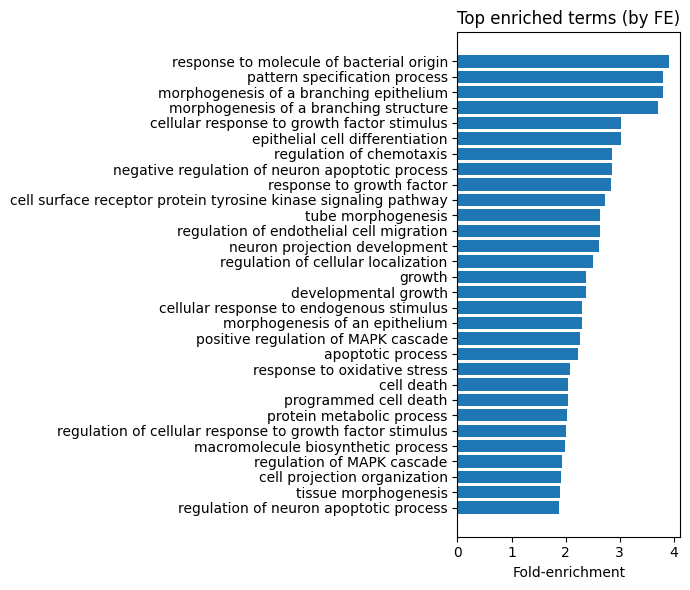

In [9]:
df2 = df.copy()
# basic size/overlap hygiene
df2 = df2[(df2["pop_count"] >= 20) & (df2["study_count"] >= 3)].copy()

def ratio_tuple(x):
    # Already a tuple like (16, 45)
    a,b = x
    return a, b

# compute FE and expected hits to avoid tiny-term artifacts
df2[["k","n"]] = df2["ratio_in_study"].map(ratio_tuple).apply(pd.Series)   # k/n
df2[["K","N"]] = df2["ratio_in_pop"].map(ratio_tuple).apply(pd.Series)     # K/N
df2["fe"] = (df2["k"]/df2["n"]) / (df2["K"]/df2["N"])
df2["expected"] = (df2["K"]/df2["N"]) * df2["n"]

# guardrails: enough observed & expected hits
df2 = df2[(df2["k"] >= 3) & (df2["expected"] >= 1)].copy()

# rank by FE (break ties with p)
df2 = df2.sort_values(["fe","p"], ascending=[False, True])

# Plot top by FE
top = df2.groupby("namespace").head(30).iloc[::-1]
plt.figure(figsize=(7,6))
plt.barh(top["name"], top["fe"])
plt.xlabel("Fold-enrichment"); plt.title("Top enriched terms (by FE)")
plt.tight_layout(); plt.show()